fix z axis scale on all plots

cut on average energy deposited (on recoil tracker ) < ~ 0.1 GeV:

    plot layer w max energy deposit as function of energy and energy deposited per layer as function of energy

repeat latest plots with mask w pdgid (recoil tracker)

    1d distributions of the variables for different kin energies using the old guns (3 different energies)
    
repeat (stecato) plots (dE/dz as function of layer for the old fixed energy guns) but:

    for ecal simhits dz =0.5mm (silicon thickness)

    for ecal rechits (map width (dz) that contains thicknes of silicon + absorber)

In [1]:
from coffea import hist
import math
from time import process_time
import os
import psutil
import uproot
import awkward as ak
%matplotlib inline

import matplotlib.pyplot as plt
import matplotlib.colors as colors
import mplhep as hep
import numpy as np
import random
plt.style.use(hep.style.CMS)

from matplotlib import colors
POPTS={'norm':colors.LogNorm(vmin=1,vmax=200)}

In [2]:
with uproot.open("data/protonpion_Oct5/ntuple_gps_proton_100.00-2000.00MeV_50k_target_events_r0007_b2_104.root") as file:
    print(file["Events"].keys())

['n_Sim_Particle', 'Sim_Particle_pdgID', 'Sim_Particle_trkID', 'Sim_Particle_mass', 'Sim_Particle_e', 'Sim_Particle_kine', 'Sim_Particle_vx', 'Sim_Particle_vy', 'Sim_Particle_vz', 'Sim_Particle_endx', 'Sim_Particle_endy', 'Sim_Particle_endz', 'Sim_Particle_px', 'Sim_Particle_py', 'Sim_Particle_pz', 'n_Recoil_SimHit', 'Recoil_SimHit_x', 'Recoil_SimHit_y', 'Recoil_SimHit_z', 'Recoil_SimHit_px', 'Recoil_SimHit_py', 'Recoil_SimHit_pz', 'Recoil_SimHit_pdgid', 'Recoil_SimHit_edep', 'Recoil_SimHit_pathLength', 'Recoil_SimHit_layer', 'n_Ecal_SimHit', 'Ecal_SimHit_edep', 'Ecal_SimHit_t', 'Ecal_SimHit_x', 'Ecal_SimHit_y', 'Ecal_SimHit_z', 'Ecal_SimHit_layer', 'n_Ecal_RecHit', 'Ecal_RecHit_amp', 'Ecal_RecHit_e', 'Ecal_RecHit_t', 'Ecal_RecHit_x', 'Ecal_RecHit_y', 'Ecal_RecHit_z', 'Ecal_RecHit_layer']


In [3]:
SimParticle_attrs = ['pdgID','trkID','mass','e','kine','vx','vy','vz','endx','endy','endz','px','py','pz']
RecoilSimHit_attrs = ['x', 'y', 'z', 'px', 'py', 'pz', 'pdgid', 'edep', 'pathLength', 'layer']
EcalSimHit_attrs = ['edep', 't', 'x', 'y', 'z', 'layer']
EcalRecHit_attrs = ['amp', 'e', 't', 'x', 'y', 'z', 'layer']


branches = {
    "Sim_Particle": SimParticle_attrs,
    "Recoil_SimHit": RecoilSimHit_attrs,
    "Ecal_SimHit": EcalSimHit_attrs,
    "Ecal_RecHit": EcalRecHit_attrs,
    "n": ["Sim_Particle", "Recoil_SimHit", "Ecal_SimHit", "Ecal_RecHit"]
}

def getData(fnames="", treeName="Events", chunks=False):
    branchlist = []
    for collection, attrs in branches.items():
        branchlist += [collection+"_"+attr for attr in attrs]
    if chunks: ldmx_dict = uproot.iterate(fnames+":"+treeName, branchlist)
    else: ldmx_dict = uproot.lazy(fnames+":"+treeName, branchlist)
    return ldmx_dict

#Repackages ldmx_dict into new dictionary of dictionaries of form
#ldmx_events={Sim_particle: {pdgID:___, trkID:___,...}, Ecal_RecHit: {amp:___, e:___, ...}, ...}
def repackage(ldmx_dict):
    evt_dict={}
    for collection in branches:    
        coll_dict={}
        for attr in branches[collection]:
            bname = "{}_{}".format(collection, attr)
            coll_dict[attr] = ldmx_dict[bname]
        evt_dict[collection] = ak.zip(coll_dict)        
    ldmx_events = ak.zip(evt_dict, depth_limit=1)
    return ldmx_events


def flat(x,axis=None): # for now must cast while waiting for coffea to catch up
    try:
        return ak.to_numpy(ak.flatten(x,axis=axis)) 
    except:
        return x

#getting rid of hits that occur at later times and earlier layers and looking at path length
#Path will only contain the first occurence of every tracker hit
def dontlookback(arr, mask=[[],[]], Start=0):
    if not ak.any(mask): mask=[[True for y in x] for x in arr]#[[True for j in i] if ak.any(i) else [False for j in i] for i in arr]
    Path=[]
    for evt1, evt2 in zip(arr, mask):
        mx=Start
        eventMask=[]
        for hit1, hit2 in zip(evt1, evt2):
            if hit1<=mx: hit2=False
            elif hit1>mx: mx=hit1
            eventMask.append(hit2)
        
        if not any(eventMask): eventMask[0]=True 
        Path.append(eventMask)
    return ak.Array(Path)
  
#Take the difference between consecutive measurements
def infinitesimalish(arr, lead=0):
    rtn=[]
    for evt in arr:
        evtArr=[]
        prev=evt[0]
        for hit in evt:
            evtArr.append(prev-hit)
            prev=hit
        
        evtArr[0]=lead
        rtn.append(evtArr)
    return ak.Array(rtn)
        
def wifMap(layerArr, zArr, mask, lead=0, oneIndexed=False):
    #Creates array of layer widths and positions. The layer number is the index to the respective values.
    numlay=ak.max(layerArr, axis=None)+1-oneIndexed
    layerZ=np.zeros(numlay)
    layerSpacing=np.zeros(numlay)
    layerSpacing[0]=lead
    #Populates layerZs and layerSpacing
    for evt1, evt2 in zip(layerArr[mask], zArr[mask]):
        for hit1, hit2 in zip(evt1, evt2):
            #layerZs
            if layerZ[hit1-oneIndexed]==0: layerZ[hit1-oneIndexed]=hit2
            #layerSpacing
            if layerSpacing[hit1-oneIndexed]==0 and layerZ[hit1-1-oneIndexed]!=0: layerSpacing[hit1-oneIndexed]=hit2-layerZ[hit1-1-oneIndexed]
            #Break if lists are done being filled
            if all(layerSpacing!=0): break    
        if all(layerSpacing!=0): break
            
    #Creates 2D array of layer widths, with same shape as layerArr, to calculate dE/dz
    WidthMap=[]
    for evt in layerArr:
        evtMask=[]
        for hit in evt:
            evtMask.append(layerSpacing[hit-oneIndexed])
        WidthMap.append(evtMask)
    
    WidthMap=ak.Array(WidthMap)
    
    return WidthMap, layerZ, layerSpacing
    

#---------------------------------- Histogram Functions---------------------------------------------------
Bins={"Sim_Particle": 
        {'pdgID':[50, 200, 2240], 'trkID':[50, 0, 100], 'mass':[20, 0, 940], 'e':[50, 2000, 3500],
         'kine':[20, 100, 2001], 'px':[50, 0, 20], 'py':[50, 0, 20], 'pz':[50, 2000, 3000],
         'endx':[50, 0, 150],'endy':[50, 0, 150], 'endz':[100, 0, 2000], 'vx':[50, 0, 10],
         'vy':[50, 0, 40], 'vz':[50, 0, 50]},
      
      "Recoil_SimHit": {'x':[50,0, 200], 'y':[50,0, 100], 'z':[50,0, 200], 'px':[50,0, 300],
                      'py':[50,0, 400], 'pz':[100,0, 300], 'pdgid':[100,0, 2500], 'edep':[50,0, 0.4],
                      'pathLength':[50,0, 1.2], 'layer':[10,0, 10]},
    
      "Ecal_SimHit": {'edep':[50, 0, 1], 't':[50, 0, 1400], 'x':[50, 0, 300],
                     'y':[50, 0, 300], 'z':[50, 200, 700], 'layer':[35, 0, 34]},
      
      "Ecal_RecHit": 
        {'amp':[50, 0, 3.6], 'e':[50, 0, 100], 't':[20, 0, 1], 
         'x':[50, 0, 250], 'y':[50, 0, 260], 'z':[50, 200, 700], 'layer':[35, 0, 34]},
      
      "n":
        {"Sim_Particle":[50, 0, 100], "Recoil_SimHit":[50, 0, 100], 
         'Ecal_SimHit':[50, 0, 90], 'Ecal_RecHit':[50, 0, 80]}
     } 

Labels={"Sim_Particle": 
        {'pdgID':'pdgID', 'trkID':'trkID', 'mass':"Mass [MeV]", 'e':"Energy [MeV]",
         'kine':"Kinetic Energy [MeV]", 'px':r"$p_x$ [MeV]", 'py':r"$p_y$ [MeV]", 'pz':r"$p_z$ [MeV]",
         'endx':r"$End_x$ [mm]",'endy':r"$End_y$ [mm]", 'endz':r"$End_z$ [mm]", 'vx':r"$v_x$ [mm]",
         'vy':r"$v_y$ [mm]", 'vz':r"$v_z$ [mm]"},
        
      "Recoil_SimHit": {'x':'x of Hit [mm]', 'y':'y of Hit [mm]', 'z':'z of Hit [mm]', 'px':'x Momentum of Hit [mm]',
                      'py':'y Momentum of Hit [mm]', 'pz':'z Momentum of Hit [mm]', 'pdgid':'pdgID', 
                      'edep':'Energy Deposited [MeV]', 'pathLength':'Path Length [mm]', 'layer':'Layer'},
    
      "Ecal_SimHit": {'edep':"Energy Deposited [MeV]", 't':"Time of Hit [ns]", 'x':'x of Hit [mm]',
                     'y':'y of Hit [mm]', 'z':'z of Hit [mm]', 'layer':'Layer'},
    
      "Ecal_RecHit": 
        {'amp':"Amplitude [mA]", 'e':"Energy [MeV]", 't':"Time [s]           ", 
         'x': "x [mm]", 'y':"y [mm]", 'z':"z [mm]", 'layer':"Layer"},
        
      "n":
        {'Sim_Particle':("Number of Hits in Event", "Sim_Particle"),
         'Recoil_SimHit':("Number of Hits in Event", "Recoil_SimHit"),   
         'Ecal_RecHit':("Number of Hits in Event", "Ecal_RecHit"),
         'Ecal_SimHit':("Number of Hits in Event", "Ecal_SimHit")} 
         }



#Makes Dictionary of hist.Hist objects in same layout as ldmx_events, where each attr. becomes a key.
#AttrDict must be a dictionary. Bin layout is determined by Bins 3d array, which is indexed with BinAttr
#and BinKey. Preferably this will be mapped out so that individual histograms may be additioned to attr.
#keys. and/or separate binning may be provided. 
def MakeHists(AttrDict, Bins):
    hists={}
    for coll in AttrDict.keys():
        attrHists={}
        for attr in AttrDict[coll]:
            attrHists[attr]=hist.Hist(coll, 
                    axes=(
                    hist.Cat("particle", "Particle"),
                    hist.Bin("e", attr, *(Bins[coll][attr]))
                    ))
            
        hists[coll]=attrHists
    return hists

#def FillHists

In [4]:
hists=MakeHists(branches, Bins)

histsAdd={}


In [19]:
#-----------------------------------------------------------------------------------------------------------------------
#----------------------------------- Additional Histograms -------------------------------------------------------------
#----------------------------------------------------------------------------------------------------------------------- 

#-----------Sim_Particle



#-----------Recoil_SimHit
#----------- One Dimensional
histsAdd["recoil_dedz"]=hist.Hist("Recoil_SimHit Events", axes=(
                            hist.Cat("particle", "Particle"),
                            hist.Bin("kine", "Kine", [100, 500, 1000, 2000]),
                            hist.Bin("e", "dE/dz [MeV/mm]", 100, 0, 2.0)))

histsAdd["recoil_sumEdep"]=hist.Hist("Recoil_SimHit Events", axes=(
                            hist.Cat("particle", "Particle"),
                            hist.Bin("kine", "Kine", [100, 500, 1000, 2000]),
                            hist.Bin("e", "Sum of Energy Deposited [MeV]", 100, 0, 10.0)))

histsAdd["recoil_avgEdep"]=hist.Hist("Recoil_SimHit Events", axes=(
                            hist.Cat("particle", "Particle"),
                            hist.Bin("kine", "Kine", [100, 500, 1000, 2000]),
                            hist.Bin("e", "Average Energy Deposited [MeV]", 100, 0, 1.0)))

histsAdd["recoil_showerMax"]=hist.Hist("Recoil_SimHit Events", axes=(
                            hist.Cat("particle", "Particle"),
                            hist.Bin("kine", "Kine", [100, 500, 1000, 2000]),
                            hist.Bin("e", "Layer with Maximum Energy Deposited", 10, 1, 11)))

histsAdd["recoil_depth"]=hist.Hist("Recoil_SimHit Events", axes=(
                            hist.Cat("particle", "Particle"),
                            hist.Bin("kine", "Kine", [100, 500, 1000, 2000]),
                            hist.Bin("e", "Furthest Layer", 10, 1, 11)))

#------------ Two Dimesional
histsAdd["recoil_dedzMIPLayer"]=hist.Hist("Recoil_SimHit Events", axes=(
                            hist.Cat("particle", "Particle"),
                            hist.Bin("kine", "Kine", [100, 500, 1000, 2000]),
                            hist.Bin("e", "dE/dZ [MeV/mm]", 100, 0, 1.5),
                            hist.Bin("s", "Layer",10, 1, 11)))

histsAdd["recoil_residualMax"]=hist.Hist("Recoil_SimHit Events", axes=(
                            hist.Cat("particle", "Particle"),
                            hist.Bin("kine", "Kine", [100, 500, 1000, 2000]),
                            hist.Bin("e", "Energy Deposited [MeV]", 100, 0, 2.0),
                            hist.Bin("s", "Relative Distance (r) to Shower Max [mm]",100, -200, 200)))

histsAdd["recoil_residualLast"]=hist.Hist("Recoil_SimHit Events", axes=(
                            hist.Cat("particle", "Particle"),
                            hist.Bin("kine", "Kine", [100, 500, 1000, 2000]),
                            hist.Bin("e", "Energy Deposited [MeV]", 100, 0, 2.0),
                            hist.Bin("s", "Distance (r) to Final Position [mm]",100, 0, 200)))

#----------- Ecal_SimHit
#----------- One Dimensional
histsAdd["ecalSim_dedz"]=hist.Hist("Ecal_SimHit Events", axes=(
                            hist.Cat("particle", "Particle"),
                            hist.Bin("kine", "Kine", [100, 500, 1000, 2000]),
                            hist.Bin("e", "dE/dz [MeV/mm]", 100, 0, 2.0)))

histsAdd["ecalSim_sumEdep"]=hist.Hist("Ecal_SimHit Events", axes=(
                            hist.Cat("particle", "Particle"),
                            hist.Bin("kine", "Kine", [100, 500, 1000, 2000]),
                            hist.Bin("e", "Sum of Energy Deposited [MeV]", 100, 0, 15.0)))

histsAdd["ecalSim_avgEdep"]=hist.Hist("Ecal_SimHit Events", axes=(
                            hist.Cat("particle", "Particle"),
                            hist.Bin("kine", "Kine", [100, 500, 1000, 2000]),
                            hist.Bin("e", "Average Energy Deposited [MeV]", 100, 0, 2.0)))

histsAdd["ecalSim_showerMax"]=hist.Hist("Ecal_SimHit Events", axes=(
                            hist.Cat("particle", "Particle"),
                            hist.Bin("kine", "Kine", [100, 500, 1000, 2000]),
                            hist.Bin("e", "Layer with Maximum Energy Deposited", 34, 0, 34)))

histsAdd["ecalSim_depth"]=hist.Hist("Ecal_SimHit Events", axes=(
                            hist.Cat("particle", "Particle"),
                            hist.Bin("kine", "Kine", [100, 500, 1000, 2000]),
                            hist.Bin("e", "Furthest Layer", 34, 0, 34)))

#----------- Two Dimensional
histsAdd["ecalSim_dedzMIPLayer"]=hist.Hist("Ecal_SimHit Events", axes=(
                            hist.Cat("particle", "Particle"),
                            hist.Bin("kine", "Kine", [100, 500, 1000, 2000]),
                            hist.Bin("e", "dE/dZ [MeV/mm]", 100, 0, 5),
                            hist.Bin("s", "Layer", 34, 0, 33)))

histsAdd["ecalSim_residualMax"]=hist.Hist("Ecal_SimHit Events", axes=(
                            hist.Cat("particle", "Particle"),
                            hist.Bin("kine", "Kine", [100, 500, 1000, 2000]),
                            hist.Bin("e", "Energy Deposited [MeV]", 100, 0, 1.5),
                            hist.Bin("s", "Relative Distance (r) to Shower Max [mm]",100, -500, 500)))


histsAdd["ecalSim_residualLast"]=hist.Hist("Ecal_SimHit Events", axes=(
                            hist.Cat("particle", "Particle"),
                            hist.Bin("kine", "Kine", [100, 500, 1000, 2000]),
                            hist.Bin("e", "Energy Deposited [MeV]", 100, 0, 1.5),
                            hist.Bin("s", "Distance (r) to Final Position [mm]",100, 0, 500)))

#---------- Ecal_RecHit
#---------- One Dimensional
histsAdd["ecalRec_dedz"]=hist.Hist("Ecal_RecHit Events", axes=(
                            hist.Cat("particle", "Particle"),
                            hist.Bin("kine", "Kine", [100, 500, 1000, 2000]),
                            hist.Bin("e", "dE/dz [MeV/mm]", 100, 0, 50.0)))

histsAdd["ecalRec_sumE"]=hist.Hist("Ecal_RecHit Events", axes=(
                            hist.Cat("particle", "Particle"),
                            hist.Bin("kine", "Kine", [100, 500, 1000, 2000]),
                            hist.Bin("e", "Sum of Energy in Event [MeV]", 100, 0, 1000)))

histsAdd["ecalRec_avgE"]=hist.Hist("Ecal_RecHit Events", axes=(
                            hist.Cat("particle", "Particle"),
                            hist.Bin("kine", "Kine", [100, 500, 1000, 2000]),
                            hist.Bin("e", "Average Energy of Event [MeV]", 100, 0, 60)))

histsAdd["ecalRec_avgAmp"]=hist.Hist("Ecal_RecHit Events", axes=(
                            hist.Cat("particle", "Particle"),
                            hist.Bin("kine", "Kine", [100, 500, 1000, 2000]),
                            hist.Bin("e", "Amplitude of Hit [MeV]", 100, 0, 1.5)))

histsAdd["ecalRec_showerMax"]=hist.Hist("Ecal_RecHit Events", axes=(
                            hist.Cat("particle", "Particle"),
                            hist.Bin("kine", "Kine", [100, 500, 1000, 2000]),
                            hist.Bin("e", "Layer with Maximum Energy", 34, 0, 34)))

histsAdd["ecalRec_depth"]=hist.Hist("Ecal_RecHit Events", axes=(
                            hist.Cat("particle", "Particle"),
                            hist.Bin("kine", "Kine", [100, 500, 1000, 2000]),
                            hist.Bin("e", "Furthest Layer", 34, 0, 34)))

#------------ Two Dimensional
histsAdd["ecalRec_dedzMIPLayer"]=hist.Hist("Ecal_RecHit Events", axes=(
                            hist.Cat("particle", "Particle"),
                            hist.Bin("kine", "Kine", [100, 500, 1000, 2000]),
                            hist.Bin("e", "dE/dZ [MeV/mm]", 100, 0, 100.0),
                            hist.Bin("s", "Layer", 34, 0, 33)))

histsAdd["ecalRec_residualMax"]=hist.Hist("Ecal_RecHit Events", axes=(
                            hist.Cat("particle", "Particle"),
                            hist.Bin("kine", "Kine", [100, 500, 1000, 2000]),
                            hist.Bin("e", "Energy Deposited [MeV]", 100, 0, 1.0),
                            hist.Bin("s", "Relative Distance (r) to Shower Max [mm]",100, -500, 500)))

histsAdd["ecalRec_residualLast"]=hist.Hist("Ecal_RecHit Events", axes=(
                            hist.Cat("particle", "Particle"),
                            hist.Bin("kine", "Kine", [100, 500, 1000, 2000]),
                            hist.Bin("e", "Energy Deposited [MeV]", 100, 0, 40),
                            hist.Bin("s", "Distance (r) to Final Position [mm]",100, 0, 500)))




In [20]:
def ProcessChunk(chunk, hists):
    ldmx_events = repackage(chunk)
    
    sim_particle = ldmx_events['Sim_Particle']
    recoil_simhit = ldmx_events['Recoil_SimHit']
    ecal_simhit = ldmx_events['Ecal_SimHit']
    ecal_rechit = ldmx_events['Ecal_RecHit']
    
    #print(ak.to_list(ecal_rechit.layer[0:20]),'\n',ak.to_list(ecal_rechit.e[0:20]),'\n',ak.to_list(sim_particle.kine[0:20]))


#------------------------------------------------------------------------------------------------------------    
#--------------------------------------- DATA MASKS/MANIPULATION --------------------------------------------
#------------------------------------------------------------------------------------------------------------    
    #Determines Kinetic Energy
    parKine=""
    if ak.all(sim_particle.kine==100):
        parKine=100
    elif ak.all(sim_particle.kine==500):
        parKine=500
    elif ak.all(sim_particle.kine==1000):
        parKine=1000
    elif (ak.all(sim_particle.kine==2000)):
        parKine=2000
    
    #Determines if data file is one for protons or pions
    par=""
    ID=0
    if ak.all(sim_particle.pdgID==2212):
        par="Proton"
        ID=2212
    elif ak.all(sim_particle.pdgID==211):
        par="Pion"
        ID=211
    
    
    #Fills all histograms in "hists" that are regular 1D hists of collection attributes
    for coll in ldmx_events.fields:
        for f in ldmx_events[coll].fields:
            hists[coll][f].fill(particle=par, e= flat(getattr(ldmx_events[coll], f)))
            
    #Removes empty events. There are a lot of empty events. 
    recoilEmptyMask=getattr(ldmx_events['n'], "Recoil_SimHit")!=0
    recoil_simhit=recoil_simhit[recoilEmptyMask]
    ecalEmptyMask=getattr(ldmx_events['n'], "Ecal_SimHit")!=0
    ecal_simhit=ecal_simhit[ecalEmptyMask]
    ecalRecEmptyMask=getattr(ldmx_events['n'], "Ecal_RecHit")!=0
    ecal_rechit=ecal_rechit[ecalRecEmptyMask]
    
    #pdgID Mask
    recoilIDMask=recoil_simhit.pdgid==ID
    
    #Scatter Masks
    recoilPath=dontlookback(recoil_simhit.layer, recoilIDMask)
    ecalPath=dontlookback(ecal_simhit.layer, Start=-1)
    ecalRecPath=dontlookback(ecal_rechit.layer, Start=-1)

    
    #MIP Masks
    recoilMIPMask=recoil_simhit.edep>=.13
    ecalSimMIPMask=ecal_simhit.edep>=.13
    ecalRecMIPMask=ecal_rechit.e>=.13
    
    #dE/dz for variious data sets
    recoilSiWidth=0.32
    ecalSiWidth=0.5
    ecalRecWidths=[2.5,1.5,1.25,3,2.75,4.5,4,5,4,5,4,5,4,5,4,5,4,5,4,5,4,5,4,5,4,8.5,7,8.5,7,8.5,7,8.5,7,8.5,7]
    
    #'''
    #NEW ATTRIBUTES FOR DEDZ ADDED TO RECOIL_SIMHITS
    recoil_simhit["dedz"]=recoil_simhit.edep/recoilSiWidth
    #recoil_dedzMIPMask=recoil_simhit.dedz>=.13/recoilSiWidth
    
    #NEW ATTRIBUTES FOR DEDZ ADDED TO ECAL_SIMHITS
    ecal_simhit["dedz"]=ecal_simhit.edep/ecalSiWidth
    #ecal_dedzMIPMask=ecal_simhit.dedz>=.13/ecalSiWidth
    
    #NEW ATTRIBUTES FOR DEDZ ADDED TO ECAL_RECHITS
    widthMap=[[ecalRecWidths[hit] for hit in evt] for evt in ecal_rechit.layer]
    widthMap=ak.Array(widthMap)
    
    ecal_rechit["dedz"]=ecal_rechit.e/widthMap
    #ecal_dedzMIPMask=ecal_rechit.dedz>=.13/widthMap
    #'''
    
    #Range of iteration for kinetic energy 2d plots
    kineRange=np.linspace(100,1981,100)
    
    #------------------------------------Data Anlaysis/Histogram Filling------------------------------------------------
    
    #---------------Sim Particle
    
    
    #---------------Recoil Tracker
    '''
    twoDMask=recoilMIPMask #&recoilIDMask
    emptiesIncluded=recoil_simhit[twoDMask]
    emptiesMask=ak.num(emptiesIncluded)>0 
    noEmpties=emptiesIncluded[emptiesMask]
    
    #Fills MIP dedz
    dedzMIP=ak.flatten(noEmpties.dedz, axis=None)
    histsAdd["recoil_dedz"].fill(particle=par, kine=parKine, e=dedzMIP)
    
    #Fills MIP dedzLayer
    dedzMIP=ak.flatten(noEmpties.dedz, axis=None)
    dedzLayer=ak.flatten(noEmpties.layer, axis=None)
    histsAdd["recoil_dedzMIPLayer"].fill(particle=par, kine=parKine, e=dedzMIP, s=dedzLayer)

    #Fills Energy Sum and Energy Average
    edepSum=ak.flatten(ak.sum(noEmpties.edep, axis=1), axis=None)
    edepAvg=ak.flatten(ak.mean(noEmpties.edep, axis=1), axis=None)

    histsAdd["recoil_sumEdep"].fill(particle=par, kine=parKine, e=edepSum)
    histsAdd["recoil_avgEdep"].fill(particle=par, kine=parKine, e=edepAvg)
    
    #Fills Shower Max 
    showerMax=np.zeros(len(noEmpties))
    showerXYZ=np.zeros((len(noEmpties), 3))
    spot=0
    for evt in noEmpties:
        mx=max(evt.edep)
        for hit in evt:
            if hit.edep==mx: 
                showerMax[spot]=(hit.layer)
                showerXYZ[spot]=[hit.x, hit.y, hit.z]
        spot+=1

    histsAdd["recoil_showerMax"].fill(particle=par, kine=parKine, e=showerMax)

    #Fills Depth
    depthMax=ak.flatten(ak.max(noEmpties.layer, axis=1), axis=None)
    histsAdd["recoil_depth"].fill(particle=par, kine=parKine, e=depthMax)
    
    #Fills ResidualMax and ResidualLast
    des=np.zeros(ak.count(noEmpties.edep, axis=None))
    positionMax=np.zeros(ak.count(noEmpties.edep, axis=None))
    Last=ak.zip({"x":ak.flatten(ak.max(noEmpties.x, axis=1), axis=None), "y":ak.flatten(ak.max(noEmpties.y, axis=1), axis=None), "z":ak.flatten(ak.max(noEmpties.z, axis=1), axis=None)})
    positionLast=np.zeros(ak.count(noEmpties.edep, axis=None))

    spot=0
    ev=0
    for evt in noEmpties:
        laymx=Last[ev]
        shwmx=showerXYZ[ev]
        for hit in evt:
            des[spot]=(hit.edep)
            distanceMax=np.sqrt((hit.x-shwmx[0])**2+(hit.y-shwmx[1])**2+(hit.z-shwmx[2])**2)
            if hit.z<shwmx[2]: distanceMax=-distanceMax
            positionMax[spot]=distanceMax

            distanceLast=np.sqrt((hit.x-laymx.x)**2+(hit.y-laymx.y)**2+(hit.z-laymx.z)**2)
            positionLast[spot]=distanceLast
            spot+=1
        ev+=1

    histsAdd["recoil_residualMax"].fill(particle=par, kine=parKine, e=des, s=positionMax)
    histsAdd["recoil_residualLast"].fill(particle=par, kine=parKine, e=des, s=positionLast)
    
    
    #'''
    #---------------Ecal_SimHits
    '''
    start=process_time()
    
    twoDMask=ecalSimMIPMask 
    emptiesIncluded=ecal_simhit[twoDMask]
    emptiesMask=ak.num(emptiesIncluded)>0 
    noEmpties=emptiesIncluded[emptiesMask]
    
    #
    stop=process_time()
    print("noEmpties:", stop-start) 
    start=process_time()
        
    #Fills MIP dedz
    dedzMIP=ak.flatten(noEmpties.dedz, axis=None)
    histsAdd["ecalSim_dedz"].fill(particle=par, kine=parKine, e=dedzMIP)
    
    #Fills MIP dedzLayer
    dedzMIP=ak.flatten(noEmpties.dedz, axis=None)
    dedzLayer=ak.flatten(noEmpties.layer, axis=None)
    histsAdd["ecalSim_dedzMIPLayer"].fill(particle=par, kine=parKine, e=dedzMIP, s=dedzLayer)

    #Fills Energy Sum and Energy Average
    edepSum=ak.flatten(ak.sum(noEmpties.edep, axis=1), axis=None)
    edepAvg=ak.flatten(ak.mean(noEmpties.edep, axis=1), axis=None)

    histsAdd["ecalSim_sumEdep"].fill(particle=par, kine=parKine, e=edepSum)
    histsAdd["ecalSim_avgEdep"].fill(particle=par, kine=parKine, e=edepAvg)

    #
    stop=process_time()
    print("dedz, eSum, eAvg:", stop-start) 
    start=process_time()
    
    #Fills Shower Max 
    showerMax=np.zeros(len(noEmpties))
    showerXYZ=np.zeros((len(noEmpties), 3))
    spot=0
    for evt in noEmpties:
        mx=max(evt.edep)
        for hit in evt:
            if hit.edep==mx: 
                showerMax[spot]=(hit.layer)
                showerXYZ[spot]=[hit.x, hit.y, hit.z]
        spot+=1

    histsAdd["ecalSim_showerMax"].fill(particle=par, kine=parKine, e=showerMax)

    #Fills Depth
    depthMax=ak.flatten(ak.max(noEmpties.layer, axis=1), axis=None)
    histsAdd["ecalSim_depth"].fill(particle=par, kine=parKine, e=depthMax)

    #
    stop=process_time()
    print("Shower Max:", stop-start) 
    start=process_time()
    
    #Fills ResidualMax and ResidualLast
    des=np.zeros(ak.count(noEmpties.edep, axis=None))
    positionMax=np.zeros(ak.count(noEmpties.edep, axis=None))
    Last=ak.zip({"x":ak.flatten(ak.max(noEmpties.x, axis=1), axis=None), "y":ak.flatten(ak.max(noEmpties.y, axis=1), axis=None), "z":ak.flatten(ak.max(noEmpties.z, axis=1), axis=None)})
    positionLast=np.zeros(ak.count(noEmpties.edep, axis=None))

    spot=0
    ev=0
    for evt in noEmpties:
        laymx=Last[ev]
        shwmx=showerXYZ[ev]
        for hit in evt:
            des[spot]=(hit.edep)
            distanceMax=np.sqrt((hit.x-shwmx[0])**2+(hit.y-shwmx[1])**2+(hit.z-shwmx[2])**2)
            if hit.z<shwmx[2]: distanceMax=-distanceMax
            positionMax[spot]=distanceMax

            distanceLast=np.sqrt((hit.x-laymx.x)**2+(hit.y-laymx.y)**2+(hit.z-laymx.z)**2)
            positionLast[spot]=distanceLast
            spot+=1
        ev+=1

    histsAdd["ecalSim_residualMax"].fill(particle=par, kine=parKine, e=des, s=positionMax)
    histsAdd["ecalSim_residualLast"].fill(particle=par, kine=parKine, e=des, s=positionLast)
        
    #
    stop=process_time()
    print("residuals:", stop-start) 
    
    #'''
    #---------------Ecal_RecHits
    #'''
    twoDMask=ecalRecMIPMask 
    emptiesIncluded=ecal_rechit[twoDMask]
    emptiesMask=ak.num(emptiesIncluded)>0 
    noEmpties=emptiesIncluded[emptiesMask]
        
    #Fills MIP dedz
    dedzMIP=ak.flatten(noEmpties.dedz, axis=None)
    histsAdd["ecalRec_dedz"].fill(particle=par, kine=parKine, e=dedzMIP)
    
    #Fills MIP dedzLayer
    dedzMIP=ak.flatten(noEmpties.dedz, axis=None)
    dedzLayer=ak.flatten(noEmpties.layer, axis=None)
    histsAdd["ecalRec_dedzMIPLayer"].fill(particle=par, kine=parKine, e=dedzMIP, s=dedzLayer)

    #Fills Energy Sum and Energy Average
    edepSum=ak.flatten(ak.sum(noEmpties.e, axis=1), axis=None)
    edepAvg=ak.flatten(ak.mean(noEmpties.e, axis=1), axis=None)

    histsAdd["ecalRec_sumE"].fill(particle=par, kine=parKine, e=edepSum)
    histsAdd["ecalRec_avgE"].fill(particle=par, kine=parKine, e=edepAvg)
    
    #Fills ampKine
    avgAmp=ak.flatten(ak.mean(noEmpties.amp, axis=1), axis=None)
    histsAdd["ecalRec_avgAmp"].fill(particle=par, kine=parKine, e=avgAmp)
        
    #Fills Shower Max 
    showerMax=np.zeros(len(noEmpties))
    showerXYZ=np.zeros((len(noEmpties), 3))
    spot=0
    for evt in noEmpties:
        mx=max(evt.e)
        for hit in evt:
            if hit.e==mx: 
                showerMax[spot]=(hit.layer)
                showerXYZ[spot]=[hit.x, hit.y, hit.z]
        spot+=1

    histsAdd["ecalRec_showerMax"].fill(particle=par, kine=parKine, e=showerMax)

    #Fills Depth
    depthMax=ak.flatten(ak.max(noEmpties.layer, axis=1), axis=None)
    histsAdd["ecalRec_depth"].fill(particle=par, kine=parKine, e=depthMax)

    #Fills ResidualMax and ResidualLast
    des=np.zeros(ak.count(noEmpties.e, axis=None))
    positionMax=np.zeros(ak.count(noEmpties.e, axis=None))
    Last=ak.zip({"x":ak.flatten(ak.max(noEmpties.x, axis=1), axis=None), "y":ak.flatten(ak.max(noEmpties.y, axis=1), axis=None), "z":ak.flatten(ak.max(noEmpties.z, axis=1), axis=None)})
    positionLast=np.zeros(ak.count(noEmpties.e, axis=None))

    spot=0
    ev=0
    for evt in noEmpties:
        laymx=Last[ev]
        shwmx=showerXYZ[ev]
        for hit in evt:
            des[spot]=(hit.e)
            distanceMax=np.sqrt((hit.x-shwmx[0])**2+(hit.y-shwmx[1])**2+(hit.z-shwmx[2])**2)
            if hit.z<shwmx[2]: distanceMax=-distanceMax
            positionMax[spot]=distanceMax

            distanceLast=np.sqrt((hit.x-laymx.x)**2+(hit.y-laymx.y)**2+(hit.z-laymx.z)**2)
            positionLast[spot]=distanceLast
            spot+=1
        ev+=1

    histsAdd["ecalRec_residualMax"].fill(particle=par, kine=parKine, e=des, s=positionMax)
    histsAdd["ecalRec_residualLast"].fill(particle=par, kine=parKine, e=des, s=positionLast)
    #------------------------------------------------------------------------------------------


In [21]:
ldmx_dict_all = getData(chunks=True, fnames="data/protonpion_Sep30/*.root")

start=process_time()
nchunk = 0
for chunk in ldmx_dict_all:
    nchunk += 1
    print('process',nchunk)
    ProcessChunk(chunk, hists)
    
stop=process_time()
print("Elapsed time during the whole program in seconds:", stop-start) 

process 1
process 2
process 3
process 4
process 5
process 6
process 7
process 8
Elapsed time during the whole program in seconds: 1485.0625


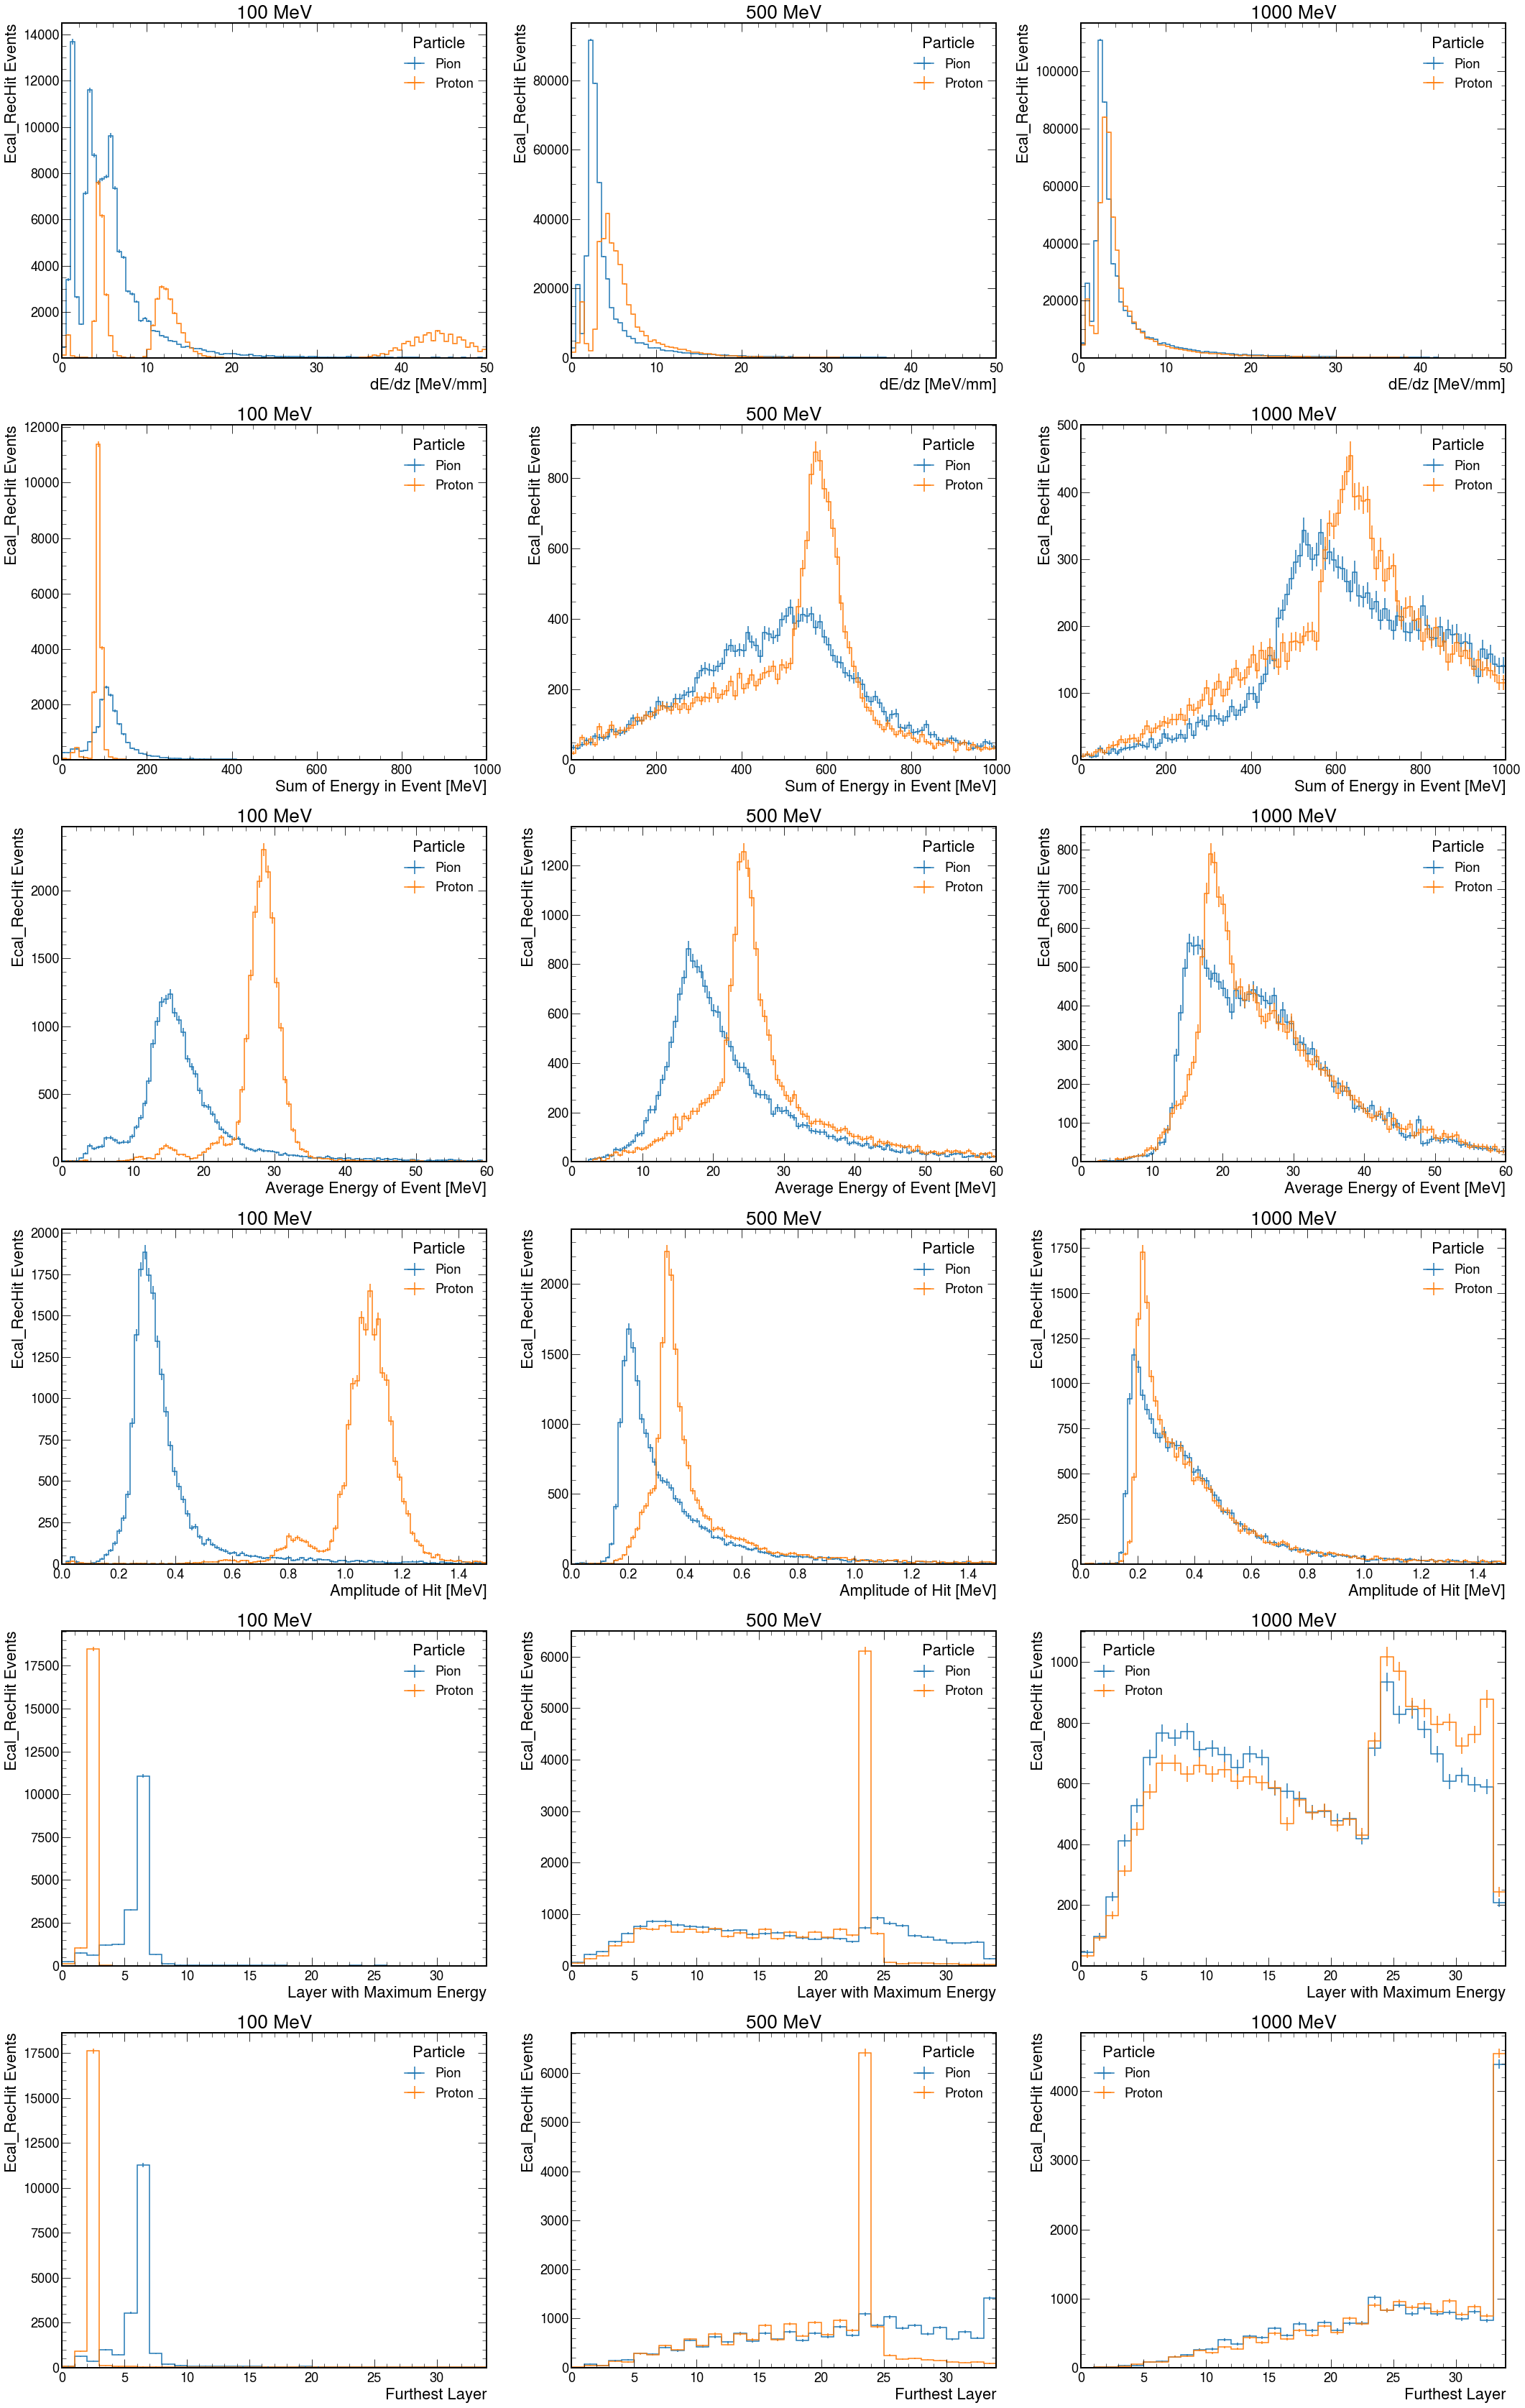

In [23]:
import ipywidgets as widgets
%matplotlib inline
from matplotlib import rcParams
from matplotlib import colors
plt.rcParams.update({'font.size': 22})

#------------------------- Plot all graphs in hists --------------------------------
'''
i=0
for coll in hists.keys():
    for key in hists[coll]:
        if i%2==0:
            fig, ax=plt.subplots(ncols=2, figsize=(22,10))
        hist.plot1d(hists[coll][key], ax=ax[i%2], clear=False, overlay="particle")
        
        if (type(Labels[coll][key])==tuple):
            ax[i%2].set_xlabel(Labels[coll][key][0])
            ax[i%2].set_ylabel(Labels[coll][key][1])
        else:
            ax[i%2].set_xlabel(Labels[coll][key])
            
        i+=1
'''
#------------------------- Plotting Widget ----------------------------------------
'''
%matplotlib widget
#Makes a list of attributes for the widget
widlist=[[coll+"-"+attr for attr in branches[coll]] for coll in branches.keys()]
WidList=np.array([])
for i in widlist:
    WidList=np.append(WidList, i)


fig, axW=plt.subplots(figsize=(10,10))

def plott(attr, compare=True):
    coll=attr[:attr.find("-")]
    key=attr[attr.find("-")+1:]
    hist.plot1d(hists[coll][key], ax=axW, overlay="particle", clear=compare)#, legend_opts={'labels':[attr]})
    
    if (type(Labels[coll][key])==tuple):
        axW.set_xlabel(Labels[coll][key][0], fontsize=18)
        axW.set_ylabel(Labels[coll][key][1], fontsize=18)
    else:
        axW.set_xlabel(Labels[coll][key], fontsize=18)
        axW.set_ylabel(coll, size=18)
    #plt.close()
    #display(fig)
   
    
_=widgets.interact(plott, attr=WidList, compare=[("True",0),("False",1)]);
#'''

'''
%matplotlib widget


def kine4D()

'''

#------------------------ Plotting Functions ----------------------------------

#'''
def oneDPlot(names):
    numP=len(names)
    fig, ax=plt.subplots(ncols=3, nrows=numP, figsize=(36, 10*numP))
    for i in range(0, numP):
            hist.plot1d(histsAdd[names[i]][:,100].sum("kine"),ax=ax[i, 0], clear=True, overlay="particle")
            ax[i, 0].set_title("100 MeV")
            hist.plot1d(histsAdd[names[i]][:,500].sum("kine"), ax=ax[i, 1], clear=True, overlay="particle")
            ax[i, 1].set_title("500 MeV")
            hist.plot1d(histsAdd[names[i]][:,1000].sum("kine"), ax=ax[i, 2], clear=True, overlay="particle")
            ax[i, 2].set_title("1000 MeV")
            


def twoDPlot(names):
    numP=len(names)*3
    fig, ax=plt.subplots(ncols=2, nrows=numP, figsize=(24, 10*numP))
    for i in range(0, numP//3):
        if names[i, 1]:
            hist.plot2d(histsAdd[names[i, 0]]["Proton"].sum("particle")[100].sum("kine"), "s", ax=ax[i*3,0], clear=True, patch_opts={'norm': colors.LogNorm()})
            hist.plot2d(histsAdd[names[i, 0]]["Pion"].sum("particle")[100].sum("kine"), "s", ax=ax[i*3,1], clear=True, patch_opts={'norm': colors.LogNorm()})
            ax[i*3, 0].set_title("100 MeV, Proton")
            ax[i*3, 1].set_title("100 MeV, Pion")
            
            hist.plot2d(histsAdd[names[i, 0]]["Proton"].sum("particle")[500].sum("kine"), "s", ax=ax[i*3+1,0], clear=True, patch_opts={'norm': colors.LogNorm()})
            hist.plot2d(histsAdd[names[i, 0]]["Pion"].sum("particle")[500].sum("kine"), "s", ax=ax[i*3+1,1], clear=True, patch_opts={'norm': colors.LogNorm()})
            ax[i*3+1, 0].set_title("500 MeV, Proton")
            ax[i*3+1, 1].set_title("500 MeV, Pion")
            
            hist.plot2d(histsAdd[names[i, 0]]["Proton"].sum("particle")[1000].sum("kine"), "s", ax=ax[i*3+2,0], clear=True, patch_opts={'norm': colors.LogNorm()})
            hist.plot2d(histsAdd[names[i, 0]]["Pion"].sum("particle")[1000].sum("kine"), "s", ax=ax[i*3+2,1], clear=True, patch_opts={'norm': colors.LogNorm()})
            ax[i*3+2, 0].set_title("1000 MeV, Proton")
            ax[i*3+2, 1].set_title("1000 MeV, Pion")
            
        else:
            hist.plot2d(histsAdd[names[i, 0]].sum("particle")[100].sum("kine"), "s", ax=ax[i*3,0], clear=True)
            hist.plot2d(histsAdd[names[i, 0]]["Pion"].sum("particle")[100].sum("kine"), "s", ax=ax[i*3,1], clear=True)
            ax[i*3, 0].set_title("100 MeV, Proton")
            ax[i*3, 1].set_title("100 MeV, Pion")
            
            hist.plot2d(histsAdd[names[i, 0]]["Proton"].sum("particle")[500].sum("kine"), "s", ax=ax[i*3+1,0], clear=True)
            hist.plot2d(histsAdd[names[i, 0]]["Pion"].sum("particle")[500].sum("kine"), "s", ax=ax[i*3+1,1], clear=True)
            ax[i*3+1, 0].set_title("500 MeV, Proton")
            ax[i*3+1, 1].set_title("500 MeV, Pion")
            
            hist.plot2d(histsAdd[names[i, 0]]["Proton"].sum("particle")[1000].sum("kine"), "s", ax=ax[i*3+2,0], clear=True)
            hist.plot2d(histsAdd[names[i, 0]]["Pion"].sum("particle")[1000].sum("kine"), "s", ax=ax[i*3+2,1], clear=True)
            ax[i*3+2, 0].set_title("1000 MeV, Proton")
            ax[i*3+2, 1].set_title("1000 MeV, Pion")
#'''

#------------------------------------- Plots ---------------------------------------------------

#--------------------------------------------------------------------------------------------------
#              All graphs have a MIP mask on them, all dEdz graphs currently lack a dz
#--------------------------------------------------------------------------------------------------
#'''
oneDNames=np.array([#"recoil_dedz", "recoil_sumEdep", "recoil_avgEdep", "recoil_showerMax", "recoil_depth",
                    #"ecalSim_dedz", "ecalSim_sumEdep", "ecalSim_avgEdep", "ecalSim_showerMax", "ecalSim_depth",
                    "ecalRec_dedz", "ecalRec_sumE", "ecalRec_avgE", "ecalRec_avgAmp", "ecalRec_showerMax", "ecalRec_depth"])

twoDNames=np.array([['recoil_dedzMIPLayer', True], ["recoil_residualMax", True], ["recoil_residualLast", True],\
       ['ecalSim_dedzMIPLayer', True], ["ecalSim_residualMax", True], ["ecalSim_residualLast", True],\
       ['ecalRec_dedzMIPLayer', True], ["ecalRec_residualMax", True], ["ecalRec_residualLast", True]])

#twoDPlot(twoDNames)
oneDPlot(oneDNames)


#print(histsAdd["ecalSim_dedzMIPLayer"]["Proton"].sum("particle")[100])
plt.show()

In [9]:
"""
#------------------------------------------------------------------------------------------------------
#----------------------------------ROC Curves----------------------------------------------------------
#------------------------------------------------------------------------------------------------------
from sklearn import metrics

piondedz=histsAdd['ecalSim_dedzKine'].values()[('Pion',)]
protondedz=histsAdd['ecalSim_dedzKine'].values()[('Proton',)]
#print(piondedz)
#print(protondedz)


#Choose a threshold  from range(lower to upper), generate the dataset for that range (cut the propio merge at that threshold)
#calculate the probability for a proton from the actual data set(sum(targetWeights_pro)/sum(merge(targetWeights_pro and _pio)))
#broadcast probability to dataset. Run metrics.roc_curve with y_true as the "dataset" and the broadcast probability as the
#y_score, and sample_weights=targetWeights

#Creates y_true binary array
def parLabel(arr, pdgID):
    return [pdgID for x in arr]

#tacks on arr2 to arr1 at the innermost dimension
def merge(arr1, arr2):
    return np.append(arr1, arr2, axis=-1)
    

#Generates ROC curves given 2d histogram arrays for proton and pion.
def ROCKdat(proton, pion, lower, upper):
    arrsize=len(proton)
    bigtrue=np.zeros(int((arrsize/2)*(arrsize+1))*2)
    bigscore=np.zeros(int((arrsize/2)*(arrsize+1))*2)
    bigweights=np.zeros(int((arrsize/2)*(arrsize+1))*2)
    step=upper/arrsize
    
    proWeights=proton
    pioWeights=pion
    proLabels=parLabel(proton, 2212)
    pioLabels=parLabel(pion, 211)
    
    #Used for determining array indices
    counter=arrsize
    for i in np.arange(0, arrsize):
        y_true=merge(proLabels[i:],pioLabels[i:])
        #Check This
        if (all(proWeights[i:]==0)):
            proton_prob=0.000001
        else:
            proton_prob=np.sum(proWeights[i:])/(np.sum(proWeights[i:])+np.sum(pioWeights[i:]))
        y_score=[proton_prob]*(arrsize-i)*2
        weights=merge(proWeights[i:], pioWeights[i:])
        
        n=arrsize-counter
        up=((n+1)*arrsize-(n*(n+1))//2)*2
        lo=up-counter*2
        bigtrue[lo:up]=y_true
        bigscore[lo:up]=y_score
        bigweights[lo:up]=weights
        counter-=1
        
    #print(bigtrue)
    return bigtrue, bigscore, bigweights
                                    
    
#For 2d histogram arrays, the rows are the de/dz, the columns are kine. 
def threeROC(histogram, numROC, fig, upper):
    proton=histogram.values()[('Proton',)]
    pion=histogram.values()[('Pion',)]
    kinesize=len(proton)
    step=kinesize/numROC
    
    for i in np.linspace(step, kinesize, numROC):
        lo=math.floor(i-step)
        up=math.floor(i)
        ytru, ysco, weig=ROCKdat(np.ndarray.flatten(proton[:, lo:up]), np.ndarray.flatten(pion[:, lo:up]), 0, upper)
        fpr, tpr, thresholds=metrics.roc_curve(ytru, ysco, pos_label=2212, sample_weight=weig)
        plt.plot(fpr, tpr, figure=fig, label="{}-{}GeV".format(0.1+round((i-step)*0.019, 3), round(0.1+i*0.019, 3)))
    
    
    
#'''  
fig1, ax1=plt.subplots(figsize=(10, 10))
threeROC(histsAdd["ecalSim_dedzKine"], 5, fig1, 0.2) 
plt.plot([0,1],[0,1],"--", figure=fig1, label="Random Classifier")
fig1.legend(loc=(0.6,0.15), fontsize=14, title="Kine Range of Data", title_fontsize=14)
title="Recoil tracker, dE/dz vs Kinetic Energy classification, TPR for Protons"
fig1.suptitle(title, ha='center', y=0.05, fontsize=14)
ax1.set_ylabel("TPR")
ax1.set_xlabel("FPR")
#'''

#'''
fig2, ax2=plt.subplots(figsize=(10, 10))
threeROC(histsAdd["recoil_dedzKine"], 5, fig2, 0.2)
plt.plot([0,1],[0,1],"--", figure=fig2, label="Random Classifier")
fig2.legend(loc=(0.6,0.15), fontsize=14, title="Kine Range of Data", title_fontsize=14)
title="Ecal SimHit, dE/dz vs Kinetic Energy classification, TPR for Protons"
fig2.suptitle(title, ha='center', y=0.05, fontsize=14)
ax2.set_ylabel("TPR")
ax2.set_xlabel("FPR")
#'''

#'''
fig3, ax3=plt.subplots(figsize=(10, 10))
threeROC(histsAdd["ecalRec_avgAmpKine"], 5, fig3, 0.8)
plt.plot([0,1],[0,1],"--", figure=fig3, label="Random Classifier")
fig3.legend(loc=(0.6,0.15), fontsize=14, title="Kine Range of Data", title_fontsize=14)
title="Ecal RecHit, Event Average Amplitude vs Kinetic Energy classification, TPR for Protons"
fig3.suptitle(title, ha='center', y=0.05, fontsize=14)
ax3.set_ylabel("TPR")
ax3.set_xlabel("FPR")
#'''    
    
#ytru, ysco, weig= ROCKdat(protondedz, piondedz, 0, 0.30)
#fpr, tpr, thresholds=metrics.roc_curve(ytru, ysco, pos_label=2212, sample_weight=weig)

#fig2, ax2=plt.subplots()
#plt.plot(fpr, tpr, figure=fig2)
"""

'\n#------------------------------------------------------------------------------------------------------\n#----------------------------------ROC Curves----------------------------------------------------------\n#------------------------------------------------------------------------------------------------------\nfrom sklearn import metrics\n\npiondedz=histsAdd[\'ecalSim_dedzKine\'].values()[(\'Pion\',)]\nprotondedz=histsAdd[\'ecalSim_dedzKine\'].values()[(\'Proton\',)]\n#print(piondedz)\n#print(protondedz)\n\n\n#Choose a threshold  from range(lower to upper), generate the dataset for that range (cut the propio merge at that threshold)\n#calculate the probability for a proton from the actual data set(sum(targetWeights_pro)/sum(merge(targetWeights_pro and _pio)))\n#broadcast probability to dataset. Run metrics.roc_curve with y_true as the "dataset" and the broadcast probability as the\n#y_score, and sample_weights=targetWeights\n\n#Creates y_true binary array\ndef parLabel(arr, pdgID